The goal of this notebook is to perform a thorough analysis of training strategies and model assessment through cross-validation and train-val-test splitting, and boostrapping and bagging. It will also aid in visualizing model performance through learning curves, accuracy, and loss across training rounds.

In [ ]:
#First load in the three files. These should be saved on your local host and donwloded from the Google Drive in the README file.
# Install the necessary packages if you haven't already. 
#We will be working with only cloud brightness and shortwave radiation.

import xarray as xr

shortwave_radiation = xr.open_dataset("C:/Users/kathe/Downloads/ReflectedSW_remapped.nc")
cloud_brightness = xr.open_dataset("C:/Users/kathe/Downloads/GrayImagery_remapped.nc")

c:\Users\kathe\OneDrive\Documents\Anaconda\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [15]:
#Perform some basic functions to make sure the files have been loaded correctly. You should see the column names, etc. 

#Print a summary of each dataset
print("Shortwave Radiation Dataset:")
print(shortwave_radiation)
print("\nCloud Brightness Dataset:")
print(cloud_brightness)


Shortwave Radiation Dataset:
<xarray.Dataset>
Dimensions:      (time: 10, latitude: 401, longitude: 441)
Coordinates:
  * time         (time) int32 91 92 93 94 95 96 97 98 99 100
  * latitude     (latitude) float64 32.0 32.02 32.05 32.08 ... 41.95 41.98 42.0
  * longitude    (longitude) float64 -125.0 -125.0 -125.0 ... -114.0 -114.0
Data variables:
    ReflectedSW  (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    title:        Reflected Shortwave Radiation Remapped
    description:  Combined RSR data over time for Julian days 91 to 100.
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RSR over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rsr_units:    W/m2

Cloud Brightness Dataset:
<xarray.Dataset>
Dimensions:      (time: 10, latit

In [16]:
#List the variable names in each dataset
print("\nVariables in Shortwave Radiation Dataset:")
print(list(shortwave_radiation.data_vars))
print("\nVariables in Cloud Brightness Dataset:")
print(list(cloud_brightness.data_vars))


Variables in Shortwave Radiation Dataset:
['ReflectedSW']

Variables in Cloud Brightness Dataset:
['GrayImagery']


In [17]:
#Check the dimensions and coordinates of each dataset
print("\nDimensions in Shortwave Radiation Dataset:")
print(shortwave_radiation.dims)

print("\nCoordinates in Shortwave Radiation Dataset:")
print(shortwave_radiation.coords)

print("\nDimensions in Cloud Brightness Dataset:")
print(cloud_brightness.dims)

print("\nCoordinates in Cloud Brightness Dataset:")
print(cloud_brightness.coords)



Dimensions in Shortwave Radiation Dataset:
Frozen({'time': 10, 'latitude': 401, 'longitude': 441})

Coordinates in Shortwave Radiation Dataset:
Coordinates:
  * time       (time) int32 91 92 93 94 95 96 97 98 99 100
  * latitude   (latitude) float64 32.0 32.02 32.05 32.08 ... 41.95 41.98 42.0
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -114.0 -114.0 -114.0

Dimensions in Cloud Brightness Dataset:
Frozen({'time': 10, 'latitude': 401, 'longitude': 441})

Coordinates in Cloud Brightness Dataset:
Coordinates:
  * time       (time) int32 91 92 93 94 95 96 97 98 99 100
  * latitude   (latitude) float64 32.0 32.02 32.05 32.08 ... 41.95 41.98 42.0
  * longitude  (longitude) float64 -125.0 -125.0 -125.0 ... -114.0 -114.0 -114.0


In [18]:
#From here on out, this dataset will be converted into a pandas dataframe. This will allow us to perform some 
# basic data analysis on the dataset and make it easier for machine learning models to process the data. 

#Load the pandas package if not already loaded

import pandas as pd

# Convert each xarray dataset to DataFrame
df_shortwave = shortwave_radiation['ReflectedSW'].to_dataframe().reset_index()
df_brightness = cloud_brightness['GrayImagery'].to_dataframe().reset_index()

# Merge DataFrames on time, latitude, and longitude
merged_df = pd.merge(df_shortwave, df_brightness,  on=["time", "latitude", "longitude"], suffixes=('_sw', '_cod'))
# Check the final structure
print(merged_df.head())


   time  latitude  longitude  ReflectedSW  GrayImagery
0    91      32.0   -125.000          NaN          NaN
1    91      32.0   -124.975          NaN          NaN
2    91      32.0   -124.950          NaN          NaN
3    91      32.0   -124.925          NaN          NaN
4    91      32.0   -124.900          NaN          NaN


In [20]:
# Drop rows with NaNs in ReflectedSW or GrayImagery
merged_df = merged_df.dropna(subset=['ReflectedSW', 'GrayImagery'])
print("Data size after dropping NaNs in ReflectedSW and GrayImagery:", merged_df.shape)


Data size after dropping NaNs in ReflectedSW and GrayImagery: (1582960, 5)


In [22]:
#With your cleaned dataset, you’re ready to split it into training, validation, and test sets. 

#Import the necessary packages:

from sklearn.model_selection import train_test_split

#Since this is unsupervised analysis, you won’t have a target variable, but you’ll still want to ensure your 
# features are correctly formatted. Here, you’ll use ReflectedSW and GrayImagery as your main features.

# Define features for analysis
features = merged_df[['ReflectedSW', 'GrayImagery']]

#First Split: Split the dataset into an initial training set (80%) and a holdout set (20%) for final testing.
#Second Split: Split the initial training set (80%) into a training set (72%) and a validation set (8%).
#This results in:

# 72% for training
# 8% for validation
# 20% for testing

# Initial split: 80% training, 20% testing
train_data, test_data = train_test_split(features, test_size=0.2, random_state=42)

# Further split the training data into 90% training and 10% validation (equivalent to 72% training, 8% validation)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print sizes to confirm
print("Training data size:", train_data.shape)
print("Validation data size:", val_data.shape)
print("Test data size:", test_data.shape)



Training data size: (1139731, 2)
Validation data size: (126637, 2)
Test data size: (316592, 2)


In [23]:
#Train Your Model: Use the train_data for training your machine learning model.
# Our appraoch is unsupervised so now we can try: 

#Fit a clustering model like KMeans. 
#Train a classification model if you introduce labels. 

#This is a simple code for a unsupervised classification model using Kmeans clustering. 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize KMeans model (e.g., with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model on the training data
kmeans.fit(train_data)

# Predict clusters for validation data
val_predictions = kmeans.predict(val_data)

# Evaluate clustering performance using silhouette score
silhouette_avg = silhouette_score(val_data, val_predictions)
print("Silhouette Score on validation set:", silhouette_avg)


Silhouette Score on validation set: 0.6291951888909139


In [24]:

#We can save the data splits for the future. 


train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


In [29]:
##Cross-validation reduces model variance and ensures stability. Here, we use KFold cross-validation to split 
# the training data into multiple folds for validation. We will continue with the KMeans clustering used above as the model, since we are performing
# unsupervised learning.

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score

# Step 1: Downsample the training data to 10%
sampled_train_data = train_data.sample(frac=0.1, random_state=42)

# Step 2: Initialize MiniBatchKMeans with fewer iterations
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, max_iter=100, batch_size=10000, random_state=42)

# Step 3: Set up 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cross_val_scores = []

# Step 4: Perform cross-validation on the sampled data
for train_index, val_index in kf.split(sampled_train_data):
    train_fold, val_fold = sampled_train_data.iloc[train_index], sampled_train_data.iloc[val_index]
    minibatch_kmeans.fit(train_fold[['ReflectedSW', 'GrayImagery']])  # Fit on train fold with selected features
    val_pred = minibatch_kmeans.predict(val_fold[['ReflectedSW', 'GrayImagery']])  # Predict on validation fold
    score = silhouette_score(val_fold[['ReflectedSW', 'GrayImagery']], val_pred)  # Calculate silhouette score
    cross_val_scores.append(score)

print("Cross-validation silhouette scores:", cross_val_scores)
print("Average silhouette score:", sum(cross_val_scores) / len(cross_val_scores))


Cross-validation silhouette scores: [0.6313526634182854, 0.6290062113059108, 0.6271077765362181]
Average silhouette score: 0.6291555504201382


In [30]:
#To test the model’s performance on diverse data subsets, try clustering on subsets based on different ranges of 
# ReflectedSW or GrayImagery. 

# Create subsets of the data based on ReflectedSW quantiles
subset1 = train_data[train_data['ReflectedSW'] < train_data['ReflectedSW'].quantile(0.33)]
subset2 = train_data[(train_data['ReflectedSW'] >= train_data['ReflectedSW'].quantile(0.33)) & (train_data['ReflectedSW'] < train_data['ReflectedSW'].quantile(0.67))]
subset3 = train_data[train_data['ReflectedSW'] >= train_data['ReflectedSW'].quantile(0.67)]

# Initialize KMeans or MiniBatchKMeans model
kmeans = MiniBatchKMeans(n_clusters=3, max_iter=100, batch_size=10000, random_state=42)

# Evaluate performance on each subset
for i, subset in enumerate([subset1, subset2, subset3], 1):
    kmeans.fit(subset[['ReflectedSW', 'GrayImagery']])  # Fit model only on relevant columns
    subset_pred = kmeans.predict(subset[['ReflectedSW', 'GrayImagery']])
    score = silhouette_score(subset[['ReflectedSW', 'GrayImagery']], subset_pred)
    print(f"Silhouette score on subset {i}:", score)



KeyboardInterrupt: 

In [31]:

#To test the model’s performance on diverse data subsets, try clustering on subsets based on different ranges of 
# ReflectedSW or GrayImagery.

# Initialize MiniBatchKMeans with fewer iterations
kmeans = MiniBatchKMeans(n_clusters=3, max_iter=50, batch_size=10000, random_state=42)

# Downsample each subset to 50%
subset1 = subset1.sample(frac=0.5, random_state=42)
subset2 = subset2.sample(frac=0.5, random_state=42)
subset3 = subset3.sample(frac=0.5, random_state=42)

# Evaluate performance on each downsampled subset
for i, subset in enumerate([subset1, subset2, subset3], 1):
    kmeans.fit(subset[['ReflectedSW', 'GrayImagery']])
    subset_pred = kmeans.predict(subset[['ReflectedSW', 'GrayImagery']])
    score = silhouette_score(subset[['ReflectedSW', 'GrayImagery']], subset_pred)
    print(f"Silhouette score on subset {i}:", score)


Silhouette score on subset 1: 0.559979349735965
Silhouette score on subset 2: 0.6051632750827906
Silhouette score on subset 3: 0.582973355260086


In [ ]:
#To perform bootstrapping and bagging for model robustness, we create multiple bootstrapped samples of the dataset, 
# train separate MiniBatchKMeans models on each sample, and then evaluate the consistency of the clustering performance across these models. 
# This approach helps assess the stability of the clusters and model robustness to variations in the data.

#Import more necessary packages 
from sklearn.utils import resample
import numpy as np

# Parameters for bootstrapping
n_bootstrap_samples = 2  # Use fewer samples initially to test runtime
bootstrap_scores = []

# Initialize the model with fewer clusters and a smaller batch size
kmeans = MiniBatchKMeans(n_clusters=2, max_iter=25, batch_size=5000, random_state=42)

# Perform bootstrapping
for i in range(n_bootstrap_samples):
    # Create a smaller bootstrap sample (25% of training data)
    bootstrap_sample = resample(
        train_data[['ReflectedSW', 'GrayImagery']], 
        replace=True, 
        n_samples=int(len(train_data) * 0.25),  # 25% of the data
        random_state=i
    )
    
    # Fit the model on the bootstrap sample
    kmeans.fit(bootstrap_sample)
    
    # Predict clusters on the same sample
    sample_pred = kmeans.predict(bootstrap_sample)
    
    # Calculate silhouette score for the bootstrap sample
    score = silhouette_score(bootstrap_sample, sample_pred)
    bootstrap_scores.append(score)
    print(f"Silhouette score for bootstrap sample {i+1}: {score}")

# Calculate average and standard deviation of silhouette scores
average_score = np.mean(bootstrap_scores)
score_std_dev = np.std(bootstrap_scores)

print("\nAverage silhouette score across bootstraps:", average_score)
print("Standard deviation of silhouette scores across bootstraps:", score_std_dev)




KeyboardInterrupt: 

In [ ]:
##After attempting to run bootrapping, which we found to be computationally time consuming we will now try bagging.
#Bagging is generally more efficient than pure bootstrapping for generating robust models because we 
# only train on a limited number of models and then aggregate their predictions. 
# Bagging also tends to work better for supervised tasks, though this is unsupervised, as it typically involves 
# combining the outputs of multiple models to improve accuracy.

#Since we are working with clustering, the most common application of bagging would be to 
# generate multiple cluster models on bootstrapped samples and then aggregate the clusters.

from sklearn.utils import resample
from scipy.stats import mode
import numpy as np

# Parameters for bagging
n_bagging_samples = 5
n_clusters = 3  # Number of clusters in KMeans
cluster_assignments = []

# Initialize the model with reduced iterations for efficiency
kmeans_model = MiniBatchKMeans(n_clusters=n_clusters, max_iter=25, batch_size=5000, random_state=42)

# Perform bagging
for i in range(n_bagging_samples):
    # Create a bootstrapped sample (e.g., 50% of the data)
    bootstrap_sample = resample(
        train_data[['ReflectedSW', 'GrayImagery']], 
        replace=True, 
        n_samples=int(len(train_data) * 0.5), 
        random_state=i
    )
    
    # Fit the model on the bootstrap sample
    kmeans_model.fit(bootstrap_sample)
    
    # Predict clusters on the full dataset and store the assignments
    full_sample_pred = kmeans_model.predict(train_data[['ReflectedSW', 'GrayImagery']])
    cluster_assignments.append(full_sample_pred)

# Convert the list of cluster assignments to a numpy array for easy manipulation
cluster_assignments = np.array(cluster_assignments)

# Aggregate the cluster assignments by taking the mode (majority vote) along axis=0
final_clusters, _ = mode(cluster_assignments, axis=0)

# Flatten the result to get final cluster labels
final_clusters = final_clusters.flatten()

# Print final cluster assignments
print("Final aggregated cluster assignments:", final_clusters)


C:\Users\kathe\AppData\Local\Temp\ipykernel_22524\4007385985.py:34: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_clusters, _ = mode(cluster_assignments, axis=0)


Final aggregated cluster assignments: [2 0 0 ... 2 2 0]


In [36]:
import pandas as pd

# Add the final cluster labels to your training data
train_data['Final_Cluster'] = final_clusters

# Calculate summary statistics for each cluster
cluster_summary = train_data.groupby('Final_Cluster')[['ReflectedSW', 'GrayImagery']].mean()
print("Cluster characteristics:")
print(cluster_summary)


Cluster characteristics:
               ReflectedSW  GrayImagery
Final_Cluster                          
0               124.864832     0.375485
1               350.218640     0.644693
2               227.635396     0.563511


C:\Users\kathe\AppData\Local\Temp\ipykernel_22524\1515292547.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  cluster_assignment_counts = np.apply_along_axis(lambda x: np.sum(x == mode(x).mode[0]), axis=0, arr=cluster_assignments)


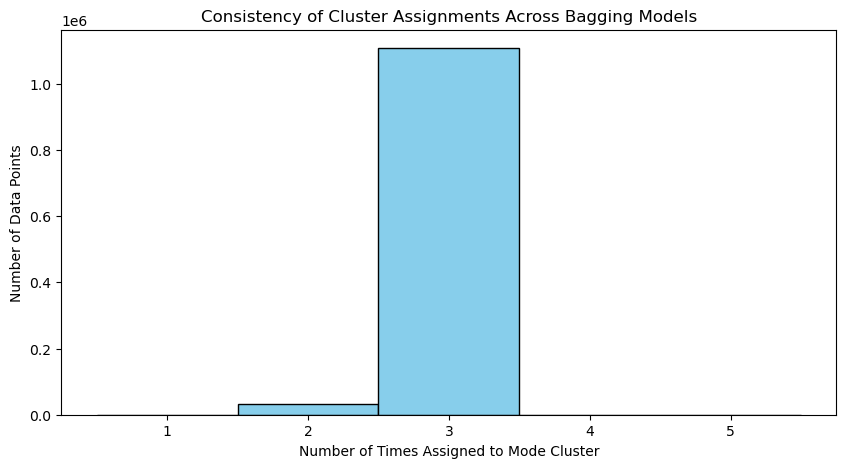

In [37]:
#Now lets try to visualize the bagging results. 

import matplotlib.pyplot as plt

# Calculate consistency by checking the frequency of the mode for each data point
# (i.e., how often the most frequent cluster assignment occurs for each data point)
cluster_assignment_counts = np.apply_along_axis(lambda x: np.sum(x == mode(x).mode[0]), axis=0, arr=cluster_assignments)

# Plot consistency
plt.figure(figsize=(10, 5))
plt.hist(cluster_assignment_counts, bins=range(1, n_bagging_samples + 2), align='left', color='skyblue', edgecolor='black')
plt.xlabel("Number of Times Assigned to Mode Cluster")
plt.ylabel("Number of Data Points")
plt.title("Consistency of Cluster Assignments Across Bagging Models")
plt.show()


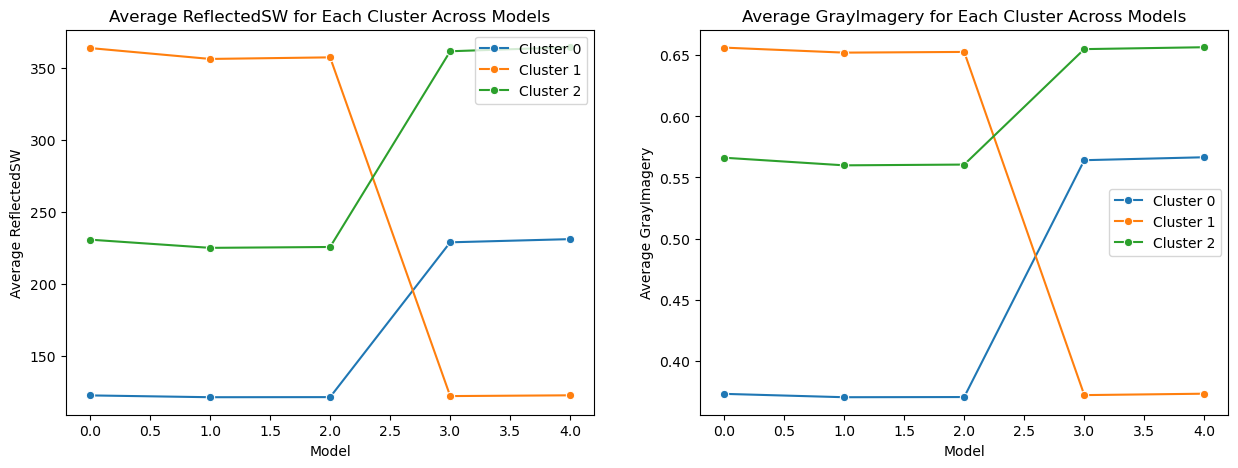

In [38]:
# Calculate average characteristics for each cluster across bagging samples
import seaborn as sns

cluster_characteristics = []
for i in range(n_bagging_samples):
    sample_df = train_data.copy()
    sample_df['Cluster'] = cluster_assignments[i]
    cluster_avg = sample_df.groupby('Cluster')[['ReflectedSW', 'GrayImagery']].mean()
    cluster_characteristics.append(cluster_avg)

# Convert list of cluster characteristics to a DataFrame for plotting
cluster_characteristics_df = pd.concat(cluster_characteristics, keys=range(n_bagging_samples))

# Plot cluster characteristics across bagging models
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ReflectedSW averages per cluster
for cluster in range(n_clusters):
    sns.lineplot(data=cluster_characteristics_df.xs(cluster, level=1)['ReflectedSW'], marker='o', ax=axes[0], label=f'Cluster {cluster}')
axes[0].set_title("Average ReflectedSW for Each Cluster Across Models")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Average ReflectedSW")

# Plot GrayImagery averages per cluster
for cluster in range(n_clusters):
    sns.lineplot(data=cluster_characteristics_df.xs(cluster, level=1)['GrayImagery'], marker='o', ax=axes[1], label=f'Cluster {cluster}')
axes[1].set_title("Average GrayImagery for Each Cluster Across Models")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Average GrayImagery")

plt.show()


In [41]:
#Now lets try to visualize the cross-validation results.


# Step 1: Downsample the training data to 10%
sampled_train_data = train_data.sample(frac=0.1, random_state=42)

# Step 2: Initialize MiniBatchKMeans with fewer iterations
minibatch_kmeans = MiniBatchKMeans(n_clusters=3, max_iter=100, batch_size=10000, random_state=42)

# Step 3: Set up 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cross_val_scores = []
cv_cluster_assignments = []  # New list to store cluster assignments for each fold

# Step 4: Perform cross-validation on the sampled data
for train_index, val_index in kf.split(sampled_train_data):
    train_fold, val_fold = sampled_train_data.iloc[train_index], sampled_train_data.iloc[val_index]
    minibatch_kmeans.fit(train_fold[['ReflectedSW', 'GrayImagery']])  # Fit on train fold with selected features
    val_pred = minibatch_kmeans.predict(val_fold[['ReflectedSW', 'GrayImagery']])  # Predict on validation fold
    score = silhouette_score(val_fold[['ReflectedSW', 'GrayImagery']], val_pred)  # Calculate silhouette score
    cross_val_scores.append(score)
    
    # Store the cluster assignments for this fold
    cv_cluster_assignments.append(val_pred)

print("Cross-validation silhouette scores:", cross_val_scores)
print("Average silhouette score:", sum(cross_val_scores) / len(cross_val_scores))

# Convert list of cluster assignments to an array for consistency analysis
cv_cluster_assignments = np.array(cv_cluster_assignments, dtype=object)  # dtype=object for varying fold sizes



Cross-validation silhouette scores: [0.6313526634182854, 0.6290062113059108, 0.6271077765362181]
Average silhouette score: 0.6291555504201382


C:\Users\kathe\AppData\Local\Temp\ipykernel_22524\65528711.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lambda x: np.sum(x == mode(x).mode[0]), axis=0, arr=cv_cluster_assignments
C:\Users\kathe\AppData\Local\Temp\ipykernel_22524\65528711.py:5: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  lambda x: np.sum(x == mode(x).mode[0]), axis=0, arr=cv_cluster_assignments


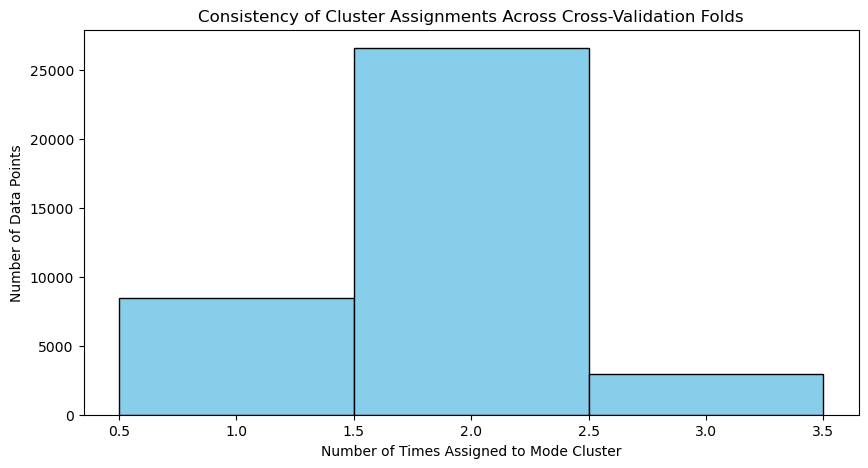

In [42]:

import matplotlib.pyplot as plt

# Calculate consistency across folds by counting occurrences of the mode assignment for each data point
cv_cluster_assignment_counts = np.apply_along_axis(
    lambda x: np.sum(x == mode(x).mode[0]), axis=0, arr=cv_cluster_assignments
)

# Plot consistency of cluster assignments across folds
plt.figure(figsize=(10, 5))
plt.hist(cv_cluster_assignment_counts, bins=range(1, kf.n_splits + 2), align='left', color='skyblue', edgecolor='black')
plt.xlabel("Number of Times Assigned to Mode Cluster")
plt.ylabel("Number of Data Points")
plt.title("Consistency of Cluster Assignments Across Cross-Validation Folds")
plt.show()



To recap this notebook, before we discuss the results, we performed train-validation-test splitting to establish a robust foundation for model evaluation and implemented cross-validation to validate model stability and consistency across folds, storing cluster assignments and analyzing silhouette scores. We also evaluated Kmeans clustering (our chosen model) on diverse subsets based on ReflectedSW or GrayImagery, testing generalization across different ranges of data. This code applied bagging by fitting multiple models on bootstrapped samples to assess clustering stability. Given the runtime challenges with bootstrapping, this was a suitable alternative that also provided a good measure of robustness. Finally, this code visualized cross-validation results with silhouette scores and plotted the consistency of cluster assignments across both bagging and cross-validation models.

Discussion of model assessment 

Initially, the train-validation-test split provided a medium level baseline silhouette score of 0.629 on the validation set, suggesting moderate clustering quality. This baseline is important for us to establish first because it sets the initial performance of the model on unseen data, which we later used for cross-validation. The cross-validation silhouette scores were 0.631, 0.629, and 0.627. These are very close to the baseline, with an average of 0.629. This consistency across folds indicates that the model performs similarly on varied portions of the data, reflecting good generality and suggesting that the clustering model is stable across different training sets. Based on the histogram of cluster assignment consistency across cross-validation folds, we see that most data points are assigned to the same cluster in two out of three folds, indicating that the majority of data points have stable cluster assignments. We also tested on diverse subsets. Based on ReflectedSW quantiles, these produced silhouette scores of 0.560, 0.605, and 0.583 for the low, medium, and high subsets, respectively. These scores are lower than the cross-validation average, especially for the low and high quantiles, which suggests that the model performs best on mid-range values of ReflectedSW. This pattern implies that the clusters may be more cohesive and separated within the central range, while the model struggles to generalize as effectively to the extreme ranges. Finally, for bagging: We see clear separation based on ReflectedSW and GrayImagery averages. These averages align with our expectations based on the dataset's structure. The clusters have clearly dentifiable characteristics. 

Overall, the model, K-means classification and clustering, shows that each cluster has idenitifiable characteristics based on our shortwave dataset and our brightness dataset. However, the model only performed at baseline with average scores for everything. It was moderate at best, not great. The bagging however, definitely improved the performance of the model. 